In [1]:
import numpy as np
import scipy.optimize
import random
from collections import defaultdict
import pandas as pd
from sklearn.utils import shuffle
import time
import matplotlib.pyplot as plt
from numpy import log
from numpy import exp
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

In [5]:
def parseFile(fname):
  for l in open(fname):
    yield eval(l)
data = pd.DataFrame(list(parseFile('train.json')))
data = shuffle(data)
data.head()

,businessID,categories,categoryID,rating,reviewHash,reviewText,reviewTime,unixReviewTime,userID
38359,B627861658,"[Bakery, Dessert Shop, Ice Cream Shop]",NaN,5.0,R865292449,This place in one word: Delicious! Their cupca...,"Jul 8, 2012",1341786654,U022953911
85460,B389403841,"[Chinese Restaurant, Asian Restaurant, Barbecu...",2.0,5.0,R050043126,Best Hong Kong Chinese food in Austin! The wal...,"May 24, 2011",1306288363,U191144638
109778,B119038646,"[Pizza Restaurant, Italian Restaurant, Brewpub]",4.0,4.0,R093581761,New Haven style pizza with both traditional an...,"Jan 31, 2014",1391226029,U513327375
64387,B015148712,"[American Restaurant, Dessert Restaurant, Beve...",0.0,5.0,R891801675,Bone marrow. Weird enough to be good.,"Apr 15, 2011",1302927416,U548636945
187027,B129374376,"[Gastropub, American Restaurant, Karaoke Bar]",0.0,2.0,R253908821,In a very competitive market like Portland you...,"Feb 25, 2014",1393346854,U133504002


In [7]:
train = data
userindex = {} # index from users and business
businessindex = {}
indexuser = {} # index to user and business
indexbusiness = {} 
userVisitHistory = {} # Stores the list business visited by a User
businessVisitHistory = {} # Stores the list of users who visites the business
userbusinessRating = {} # rating given by a user for a particular business
userCats = {} # Categories of business visited previously by a user
businessCats = {} # Category of a particular business
businessvisitcount = {} # Number of visits to a business
userRatinghistory = {} # Prior ratings given by a particular user
businessRatinghistory = {} # Prior ratings given to a business

temp = list( np.unique( list(train['userID']) ) )
for a in range(len(temp)) :
    userindex[ temp[a] ] = a
    indexuser[a] = temp[a]
    userVisitHistory[ temp[a] ] = []
    userCats[ temp[a] ] = []
    userRatinghistory[ temp[a] ] = []
    
temp = list( np.unique( list( train['businessID']) ) )
for a in range(len(temp)):
    businessindex[ temp[a] ] = a
    indexbusiness[a] = temp[a]
    businessVisitHistory[ temp[a] ] = []
    businessCats[ temp[a] ] = []
    businessvisitcount[ temp[a] ] = 0
    businessRatinghistory[ temp[a] ] = []

for u,b,r,c in zip( train['userID'], train['businessID'], train['rating'], train['categories'] ) :
    # add business visited by user u to its dictionary value
    userVisitHistory[u].append(b) 
    businessVisitHistory[b].append(u)
    userVisitHistory[u] = list( set( userVisitHistory[u] ) )
    businessVisitHistory[b] = list( set( businessVisitHistory[b]) )
    userbusinessRating[u+b] = r           
    userCats[u] = list( set( userCats[u] + c) )
    businessCats[b] = list( set( businessCats[b] + c) )
    businessvisitcount[b] += 1
    userRatinghistory[u].append(r)
    businessRatinghistory[b].append(r)


## Predict if a user would visit a business


In [26]:
BusinessSim = np.zeros((len(businessindex.keys()) , len(businessindex.keys() )) ) 
n = len( businessindex.keys() )
for i1 in range(n) :
    for i2 in range(i1+1) :
        b1, b2 = indexbusiness[i1] , indexbusiness[i2]
        a,b = businessVisitHistory[b1], businessVisitHistory[b2]
        BusinessSim[i1,i2] = BusinessSim[i2,i1] =  float( len(set(a)&set(b))/len(set(a)|set(b)))


In [ ]:
UserSim = np.zeros((len(userindex.keys()) , len(userindex.keys()) ) )
n = len(userindex.keys()) 
for i1 in range(n) :
    for i2 in range(i1+1) :
        u1, u2 = indexuser[i1] , indexuser[i2]
        a,b = userVisitHistory[u1], userVisitHistory[u2]
        # Jaccard similarity of businesses
        UserSim[i1,i2] = UserSim[i2,i1] =  float( len(set(a)&set(b))/len(set(a)|set(b)))


In [27]:
# running model on test data and writing to file
flag = 0
pred = []
predictions = open("predictions_Visit.txt", 'w')
for l in open("pairs_Visit.txt"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,i = l.strip().split('-')
    if i in businessVisitHistory.keys() and u in userVisitHistory.keys():
        temp1 = np.max([BusinessSim[businessindex[i], businessindex[b]] for b in userVisitHistory[u] ]) 
        if temp1 > 0 :   
            predictions.write(u + '-' + i + ",1\n")
            pred.append(1)
        else :
            predictions.write(u + '-' + i + ",0\n")
            pred.append(0)
    else :
        predictions.write(u + '-' + i + ",0\n")
        pred.append(0)
    flag = 0

predictions.close()

## Predict the rating a user would give to a business

In [8]:
betau = {} # beta values for each user
betai = {} # beta values for each business
gammai = {} # gamma values for business
gammau = {} # gamma values for users

train = data[:150000] # training and validation data
val = data[150000:]

N = len(train['userID'])
userVisitHistory = {} # Stores the list business visited by a User
businessVisitHistory = {} # Stores the list of users who visites the business
userbusinessRating = {} # rating given by a user for a particular business
temp = list( np.unique( train['userID'])) 
for a in range(len(temp)) :
    userVisitHistory[ temp[a] ] = []
temp = list( np.unique( train['businessID'])) 
for a in range(len(temp)):
    businessVisitHistory[ temp[a] ] = []
for u,b,r in zip( train['userID'], train['businessID'], train['rating'] ) :
    # add business visited by user u to its dictionary value
    userVisitHistory[u].append(b) 
    businessVisitHistory[b].append(u)
    userVisitHistory[u] = list( set( userVisitHistory[u] ) )
    businessVisitHistory[b] = list( set( businessVisitHistory[b]) )
    userbusinessRating[u+b] = r    
    
for a in train['userID'] :
    betau[ a ] = 0
    gammau[ a ] = list( np.random.rand(n_gamma) )
for a in train['businessID'] :
    betai[ a ] = 0
    gammai[ a ] = list( np.random.rand(n_gamma) )

n_gamma = 3 # dimensions of gamma matrices
alpha = 0 
eta = 0.005 # learning rate
niter = 1
for lam in [5]: # lamda 3 has best RMSE 
    count = 0
    mse = [ ]
    while count < niter  :
        count += 1
        sum1 = 0
        for u,i in zip( train['userID'], train['businessID'] ) :
            sum1 += userbusinessRating[u+i] - betau[u] - betai[i] - np.dot(gammau[u],gammai[i])
        alpha = sum1/N
        
        sum1 = defaultdict(float)
        for u,i in zip( train['userID'], train['businessID'] ) :
            sum1[u] += ( userbusinessRating[u+i] - alpha - betai[i] - 
                        np.dot(gammau[u],gammai[i]) )
        for u in betau :
            betau[u] = sum1[u]/(lam + len(userVisitHistory[u] ))
 
        sum1 = defaultdict(float)
        for u,i in zip( train['userID'], train['businessID'] ) :
            sum1[i] += ( userbusinessRating[u+i] - alpha - betau[u] 
                         - np.dot(gammau[u],gammai[i]) )
        for i in betai :
            betai[i] = sum1[i]/(lam + len(businessVisitHistory[i] ))
        
        for t in range(10) :
            eta = 0.005
            if t>=4:
                eta = 0.001
            for k in range( n_gamma ) :
                sum1 = defaultdict(float)
                for u,i in zip( train['userID'], train['businessID'] ) :
                    sum1[u] += (alpha+betai[i]+betau[u]+np.dot(gammau[u],gammai[i]) - 
                               userbusinessRating[u+i]) *2*gammai[i][k]
                for u in gammau : 
                    sum1[u] += 2*lam*gammau[u][k]
                    gammau[u][k] -= eta*sum1[u]
        
        for t in range(10) :
            eta = 0.005
            if t>=4:
                eta = 0.001
            for k in range( n_gamma ) :
                sum2 = defaultdict(float)
                for u,i in zip( train['userID'], train['businessID'] ) :
                    sum2[i] += (alpha+betai[i]+betau[u]+np.dot(gammau[u],gammai[i]) - 
                               userbusinessRating[u+i]) *2*gammau[u][k]
                for i in gammai : 
                    sum2[i] += 2*lam*gammai[i][k]
                    gammai[i][k] -= eta*sum2[i]

        #  Checking traing error
        sum1 = 0
        for u,i in zip( train['userID'], train['businessID'] ) :
            sum1 += (userbusinessRating[u+i] -alpha -betau[u] -betai[i] -np.dot(gammau[u],gammai[i]) )**2
        mse.append( ( np.sqrt( sum1/N ) ) )
        print(mse[-1])
    
    plt.plot(mse, alpha=0.8, marker = 'o',label = 'lam = ' + str(lam) )
    
    # Check error on validation set 
    sum1 = 0
    temp = 0
    for u,i,r in zip( val['userID'], val['businessID'],val['rating'] ) : 
        temp = alpha
        if u in betau :
            temp += betau[u] 
        if i in betai :
            temp += betai[i] 
        if u in betau and i in betai :
            temp += np.dot(gammau[u],gammai[i]) 
        sum1 += (r - temp)**2
        
    print ('RMSE on val  = ', np.sqrt(sum1/N), 'for lamda = ',lam)

plt.legend()
plt.title('Train error vs iterations')
plt.show()

# ngamma = 3, eta = 0.005,0.001, lam = 5

NameError: name 'n_gamma' is not defined

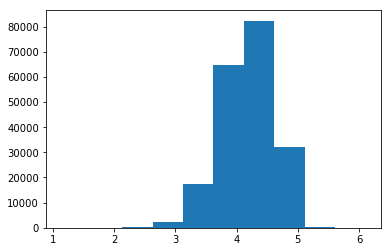

In [34]:
val1 = data
predr = []
for u,i,r in zip( val1['userID'], val1['businessID'],val1['rating'] ) : 
    temp = alpha + betau[u] + betai[i] + np.dot(gammau[u],gammai[i]) 
    predr.append( temp )
#     predr.append( temp )
plt.hist(predr)
plt.show()

In [35]:
count = 0 
predictions = open("predictions_Rating.txt", 'w')
for l in open("pairs_Rating.txt"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,i = l.strip().split('-')
    r = alpha
    if u in betau and i in betai :
        r += betau[u] + betai[i] + np.dot(gammau[u],gammai[i]) 
#     else :
#         r+= np.mean(list(betau.values())) + np.mean(list(betai.values()))
#         r+= np.dot( np.mean( list(gammai.values()), axis = 0 ),np.mean( list(gammau.values()), axis = 0 ) )
       
    if r>5 :
        r = 5
    if r<2 :
        r = 2
    predictions.write(u + '-' + i + ',' + str(r) + '\n')
    count+= 1
predictions.close()
count


20000